*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 15: Classifying Images with Deep Convolutional Neural Networks (Part 2/2)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-03 

numpy 1.17.3
scipy 1.3.1
matplotlib 3.1.1
tensorflow 2.0.0
tensorflow_datasets 1.2.0


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Gender classification from face images using CNN


### Loading the CelebA dataset

In [3]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)
print(celeba.keys())

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print('Train set:  {}'.format(count_items(celeba_train)))
print('Validation: {}'.format(count_items(celeba_valid)))
print('Test set:   {}'.format(count_items(celeba_test)))

dict_keys(['test', 'train', 'validation'])
Train set:  162770
Validation: 19867
Test set:   19962


In [4]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

print('Train set:  {}'.format(count_items(celeba_train)))
print('Validation: {}'.format(count_items(celeba_valid)))

Train set:  16000
Validation: 1000


### Image transformation and data augmentation

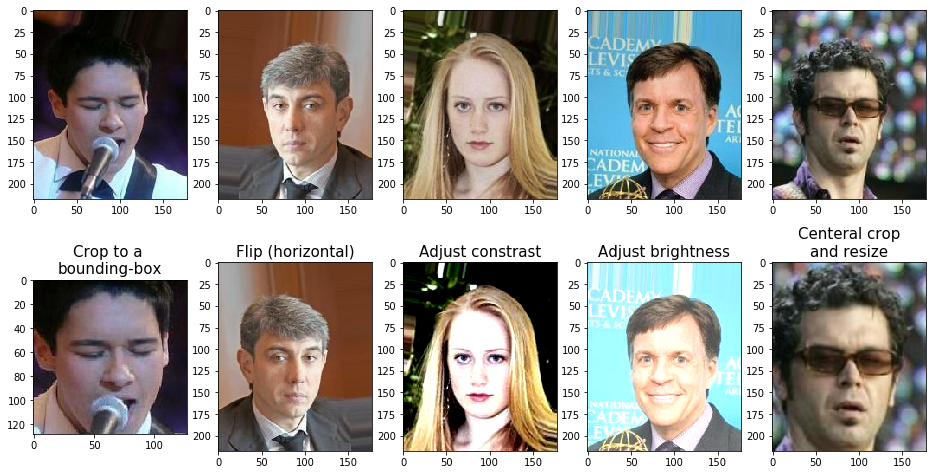

In [5]:
## take 5 examples:
examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
ax.set_title('Crop to a \nbounding-box', size=15)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
ax.set_title('Flip (horizontal)', size=15)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
ax.set_title('Adjust brightness', size=15)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
ax.set_title('Centeral crop\nand resize', size=15)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)
img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))

# plt.savefig('figures/15_14.png', dpi=300)
plt.show()

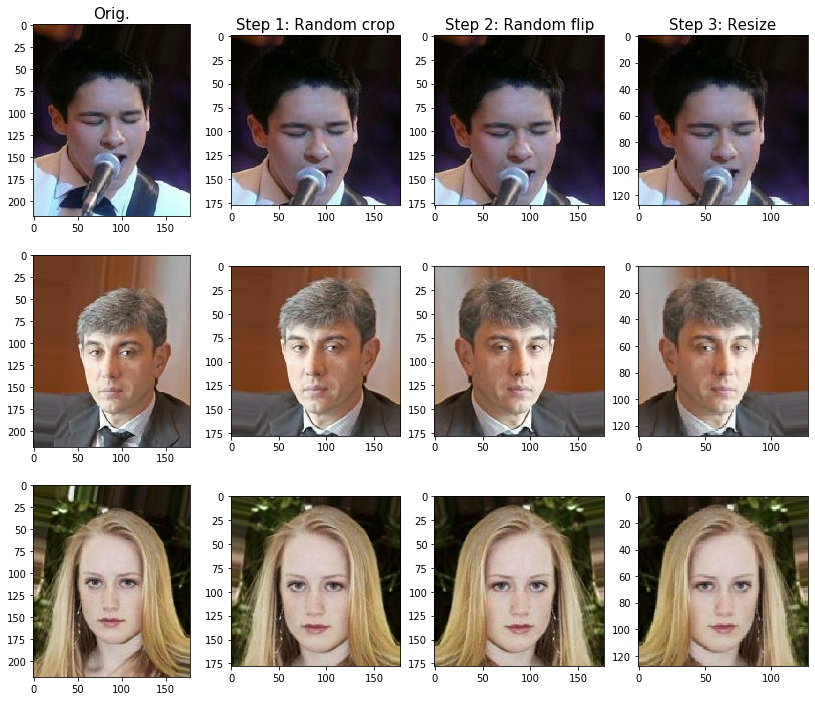

In [6]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))

for i,example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

# plt.savefig('figures/15_15.png', dpi=300)
plt.show()

In [7]:
def preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

## testing:
#item = next(iter(celeba_train))
#preprocess(item, mode='train')

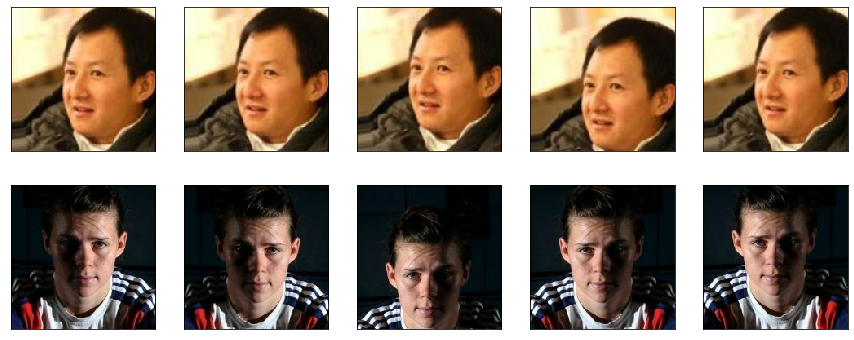

In [8]:
tf.random.set_seed(1)

ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)

ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))

fig = plt.figure(figsize=(15, 6))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    
#plt.savefig('figures/15_16.png', dpi=300)
plt.show()

In [9]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
print(steps_per_epoch)

ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

500.0


### Training a CNN gender classifier

* **Global Average Pooling**

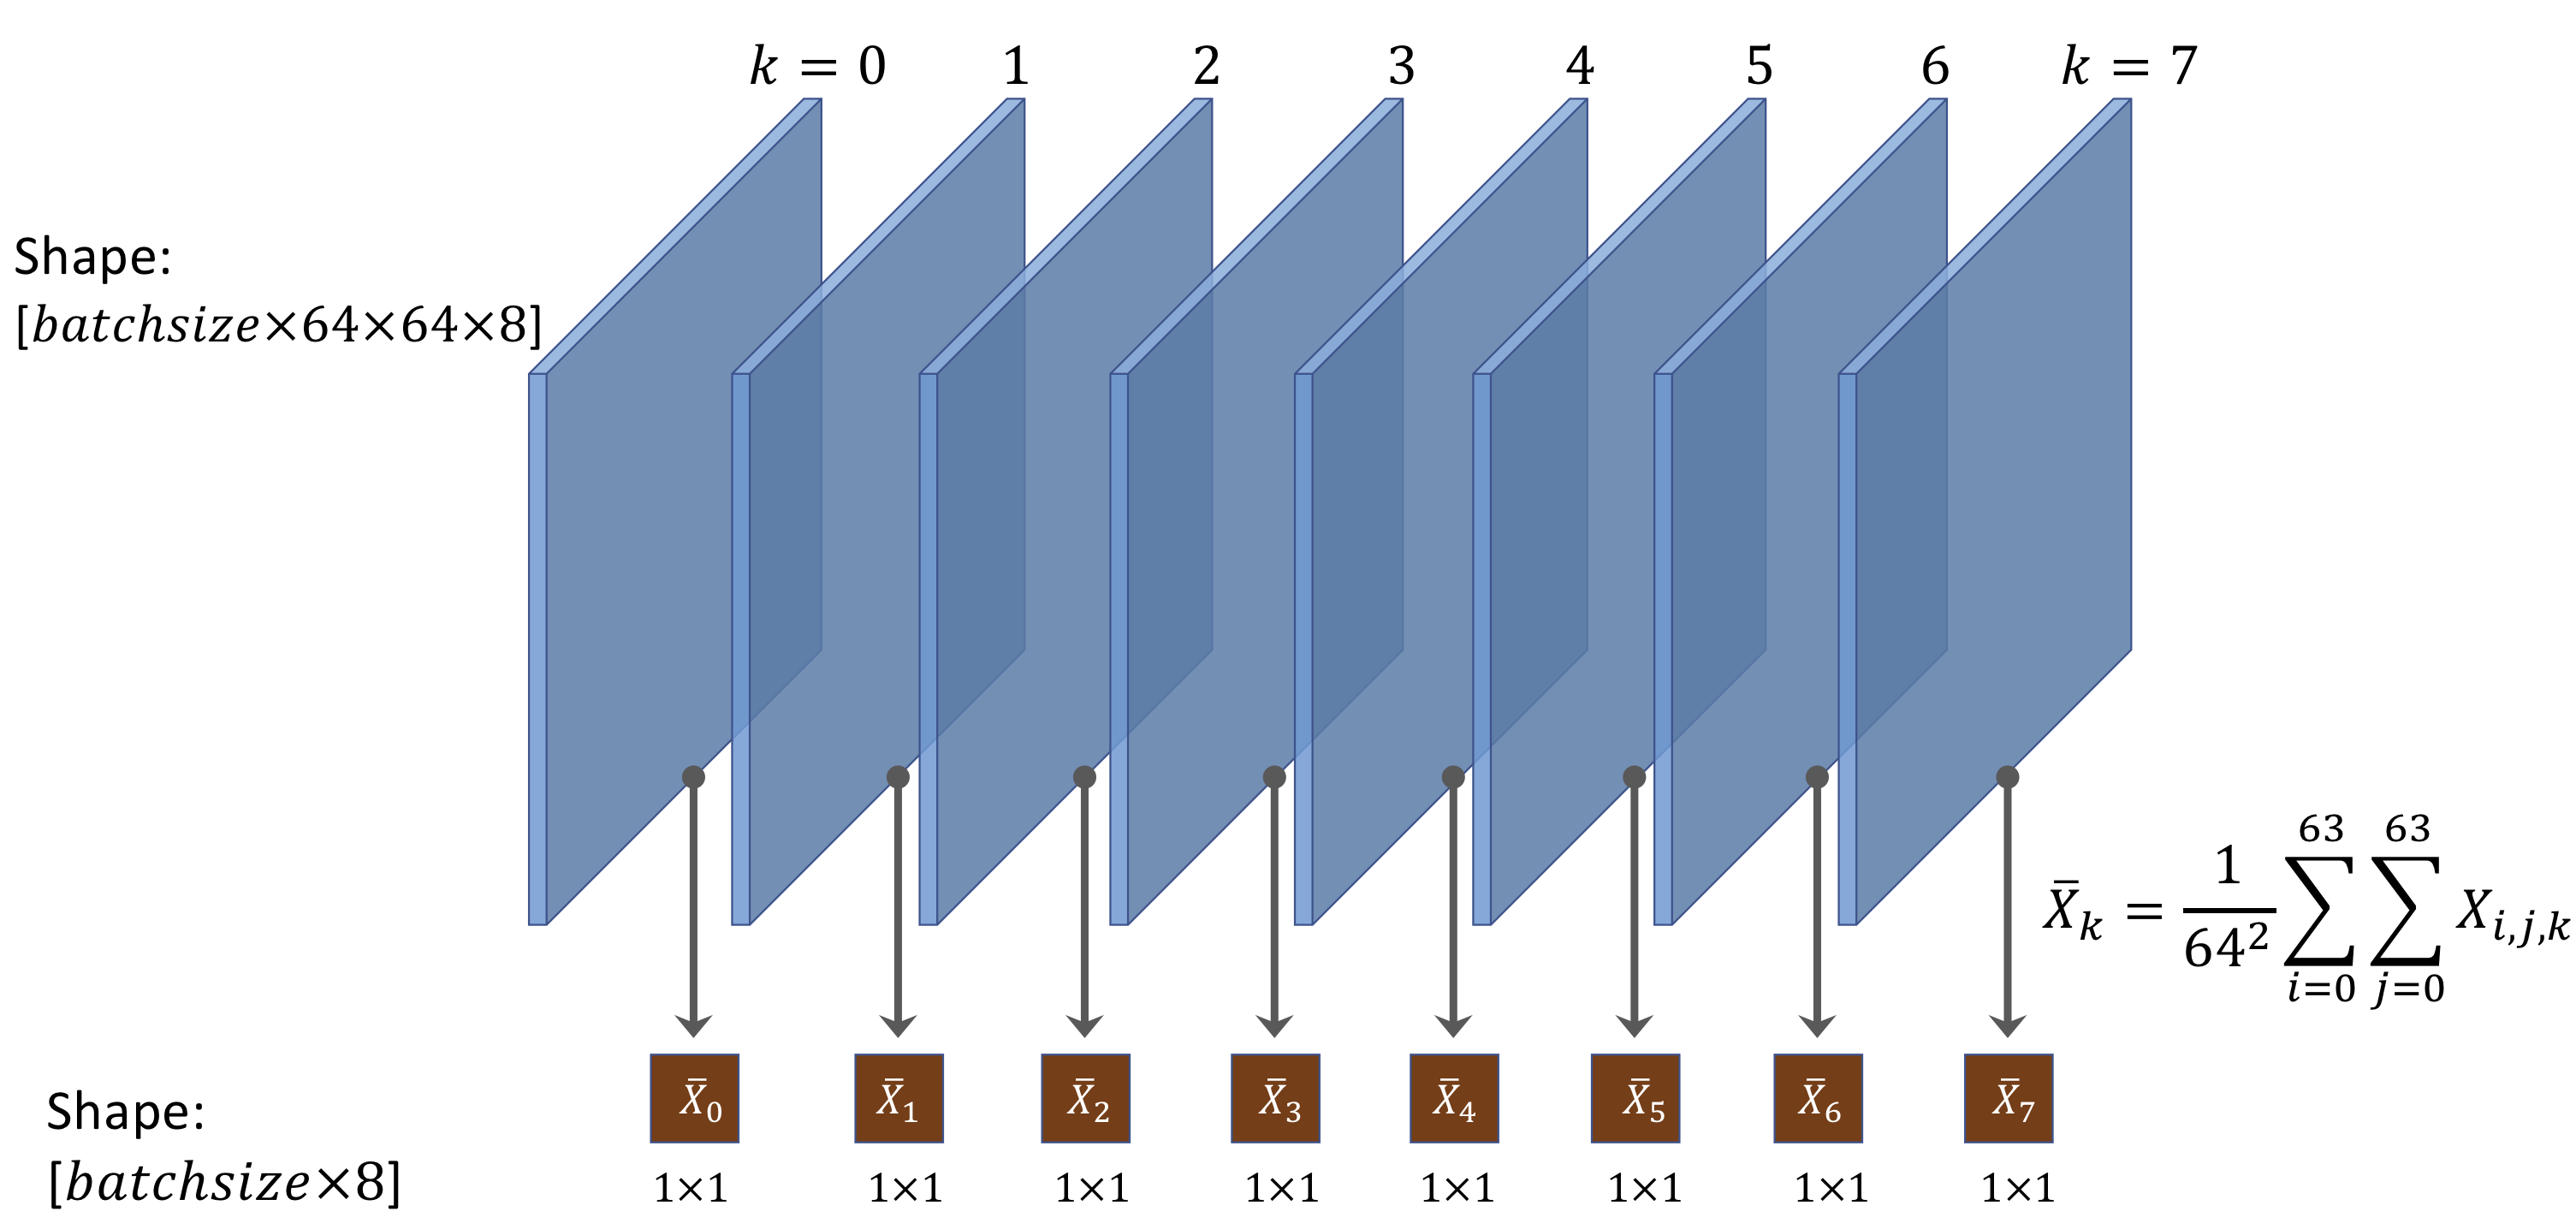

In [10]:
Image(filename='images/15_13.png', width=800)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu'),
])

In [12]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

In [13]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 256])

In [14]:
model.add(tf.keras.layers.Dense(1, activation=None))

In [15]:
tf.random.set_seed(1)

model.build(input_shape=(None, 64, 64, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  7

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=20, steps_per_epoch=steps_per_epoch)


Train for 500.0 steps
Epoch 1/20
500/500 [==============================] - 38s 77ms/step - loss: 0.6223 - accuracy: 0.6254 - val_loss: 0.5901 - val_accuracy: 0.7440
Epoch 2/20
500/32 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 37s 74ms/step - loss: 0.4837 - accuracy: 0.7145 - val_loss: 0.4513 - val_accuracy: 0.7610
Epoch 3/20
500/32 [==========================================================================================================================================================================================================================================

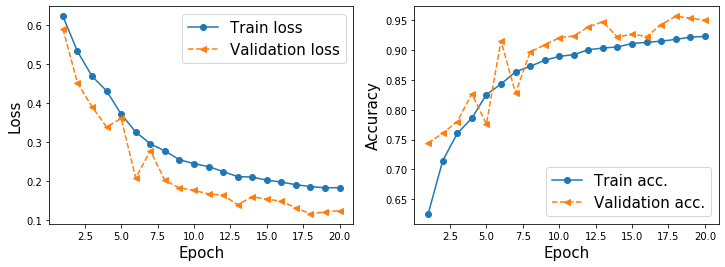

In [17]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_18.png', dpi=300)
plt.show()

In [18]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 94.47%


In [19]:
history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epoch)

Train for 500.0 steps
Epoch 21/30
500/500 [==============================] - 36s 71ms/step - loss: 0.1789 - accuracy: 0.9221 - val_loss: 0.1143 - val_accuracy: 0.9570
Epoch 22/30
500/32 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 35s 69ms/step - loss: 0.1661 - accuracy: 0.9259 - val_loss: 0.1206 - val_accuracy: 0.9540
Epoch 23/30
500/32 [=======================================================================================================================================================================================================================================

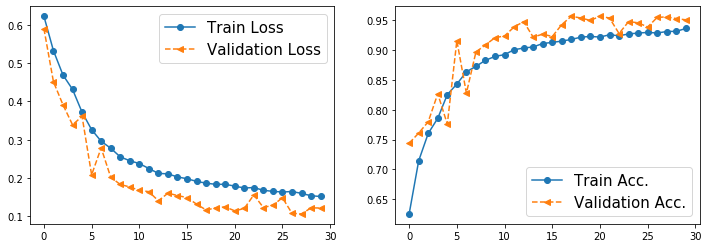

In [20]:
hist2 = history.history
x_arr = np.arange(len(hist['loss'] + hist2['loss']))


fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss']+hist2['loss'], 
        '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss']+hist2['val_loss'],
        '--<', label='Validation Loss')
ax.legend(fontsize=15)


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy']+hist2['accuracy'], 
        '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy']+hist2['val_accuracy'], 
        '--<', label='Validation Acc.')
ax.legend(fontsize=15)
plt.show()

In [21]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 95.16%


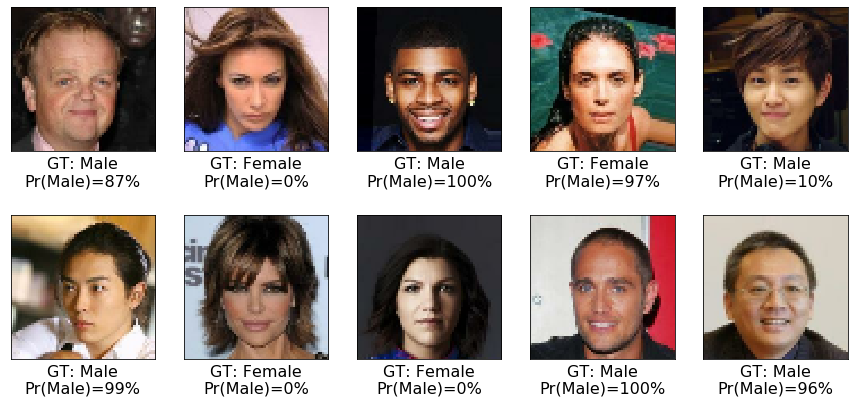

In [22]:
ds = ds_test.unbatch().take(10)

pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(Male)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
#plt.savefig('figures/figures-15_19.png', dpi=300)
plt.show()

In [23]:
model.save('models/celeba-cnn.h5')

...


## Summary

...



## Appendix:

### The effect of initial shuffling

In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd


## MNIST dataset
#datasets = tfds.load(name='mnist')
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)

**Notice that count-of-labels in mnist_valid did not stay the same when the dataset is loaded with using Builder and specifying `mnist_bldr.as_dataset(shuffle_files=False)`**

In [25]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter
    
print('Count of labels:', count_labels(mnist_valid))
print('Count of labels:', count_labels(mnist_valid))

Count of labels: Counter({1: 13, 0: 13, 9: 12, 4: 11, 5: 11, 2: 10, 6: 9, 7: 8, 3: 7, 8: 6})
Count of labels: Counter({1: 13, 0: 13, 9: 12, 4: 11, 5: 11, 2: 10, 6: 9, 7: 8, 3: 7, 8: 6})


In [26]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd


## MNIST dataset
datasets = tfds.load(name='mnist')
#mnist_bldr = tfds.builder('mnist')
#mnist_bldr.download_and_prepare()
#datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)

**Notice that count-of-labels in mnist_valid did not stay the same when the dataset is loaded with `tfds.load()`**

In [27]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter
    
print('Count of labels:', count_labels(mnist_valid))
print('Count of labels:', count_labels(mnist_valid))

Count of labels: Counter({2: 15, 7: 13, 0: 11, 1: 11, 9: 10, 4: 10, 6: 10, 5: 9, 8: 6, 3: 5})
Count of labels: Counter({9: 17, 4: 15, 6: 13, 7: 12, 1: 11, 0: 10, 8: 6, 3: 6, 5: 6, 2: 4})


----

Readers may ignore the next cell.

In [28]:
! python ../.convert_notebook_to_script.py --input ch15_part2.ipynb --output ch15_part2.py

[NbConvertApp] Converting notebook ch15_part2.ipynb to script
[NbConvertApp] Writing 13198 bytes to ch15_part2.py
